In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [10]:
df = pd.read_json('photos.json', lines=True)

In [11]:
df.head(5)

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [12]:
df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [13]:
df['label'].isnull().sum()

0

In [14]:
count_type = []
for i in df['label'].unique():
    count_type.append(df['label'].tolist().count(i))
    print(f"{i} class - {df['label'].tolist().count(i)} images")

inside class - 56031 images
outside class - 18569 images
drink class - 15670 images
food class - 108152 images
menu class - 1678 images


<BarContainer object of 5 artists>

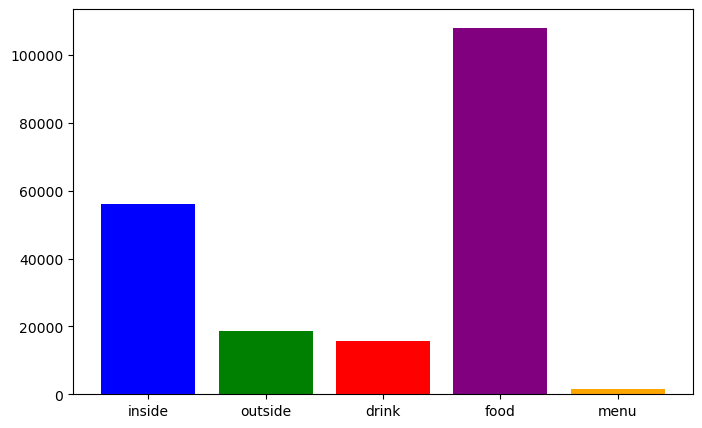

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(df['label'].unique(), count_type, color=['blue', 'green', 'red', 'purple', 'orange'])


- There is a **class imbalance**, as the menu class contains less than 1% of the images.
- The majority of the images belong to the **food** and **drink** categories.
- To address the class imbalance, we will sample **1,678 images** from each class.


# Pre-Processing the Images

In [16]:
def load_images(data, image_folder):
    """
    Load images from a dataset, resizing and normalizing them, while limiting the number 
    of images per class to avoid class imbalance.
    
    Input:
    data : pd.DataFrame
        DataFrame containing the image information such as 'photo_id' and 'label'.
    image_folder : str
        The path to the folder where the images are stored.

    Return:
    images : np.ndarray
        Numpy array containing the preprocessed images.
    labels : np.ndarray
        Numpy array containing the corresponding labels for the images.
    """
    
    images, labels = [], []  # Lists to store images and their labels
    
    # Keep track of the count of images loaded for each label
    label_data_count = {
        "inside" : 0,
        "outside" : 0,
        "drink" : 0,
        "food" : 0,
        "menu" : 0
    }

    max_image_count = 1678  # Maximum number of images per class to maintain balance
    height = width = 128    # Size of the image can be(128, 256, 512)

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        
        # Stop if the maximum image count for all labels is reached
        if all(value == max_image_count for value in label_data_count.values()):
            break
        
        try:
            photo_id = row['photo_id']  # Get the photo ID
            label = row['label']  # Get the corresponding label
            
            # Check if the current label still needs more images
            label_count = label_data_count.get(label)
            if label_count < max_image_count:
                
                # Build the path to the image file
                image_path = os.path.join(image_folder, f"{photo_id}.jpg")
                
                # Load and preprocess the image (resize and normalize)
                image = load_img(image_path, target_size=(height, width))  # Resizing the image
                image = img_to_array(image) / 255.0  # Normalizing the image to range [0, 1]
                
                # Append the preprocessed image and its label
                images.append(image)
                labels.append(label)
                
                # Update the count for the current label
                label_data_count.update({label : label_data_count.get(label) + 1})
        
        except UnidentifiedImageError:
            # Handle cases where the file is not a valid image
            print(f"Skipping file {row['photo_id']}, not an image.")
    
    # Convert lists to numpy arrays and return
    return np.array(images), np.array(labels)

image_folder = 'photos/'
X, y = load_images(df, image_folder)

Skipping file ydm3g1wUWSxJnMPgHk2JhQ, not an image.


## Feature Engineering

In [17]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Label encoding 
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

- we neet to label enccode before one hot encoding since to_categorical does not take string values as input

In [19]:
# Defining th model, using relu activation with 3 layers and a dense layer with a softmassx output for multiclass classification
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

c:\Users\Rajesh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Compiling the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [21]:
cnn_history = cnn_model.fit(X_train, y_train_encoded,
                             epochs=10,
                             validation_data=(X_test, y_test_encoded),
                             batch_size=32)

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 238ms/step - accuracy: 0.4220 - loss: 1.3752 - val_accuracy: 0.6496 - val_loss: 0.9449
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 267ms/step - accuracy: 0.6524 - loss: 0.9088 - val_accuracy: 0.6973 - val_loss: 0.8463
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 60s 287ms/step - accuracy: 0.7496 - loss: 0.6842 - val_accuracy: 0.7306 - val_loss: 0.7605
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 53s 254ms/step - accuracy: 0.8122 - loss: 0.5133 - val_accuracy: 0.7360 - val_loss: 0.7709
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.8711 - loss: 0.3425 - val_accuracy: 0.7515 - val_loss: 0.7746
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.9403 - loss: 0.1864 - val_accuracy: 0.7282 - val_loss: 0.9668
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.9663 - loss: 0.1082 - val_accuracy: 0.7348 - val_loss: 1.2308
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.9916 - loss: 0

Training accuracy suggests that the model is overfitting

In [22]:
# Prediction 
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


In [23]:
# Accuracy Score
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


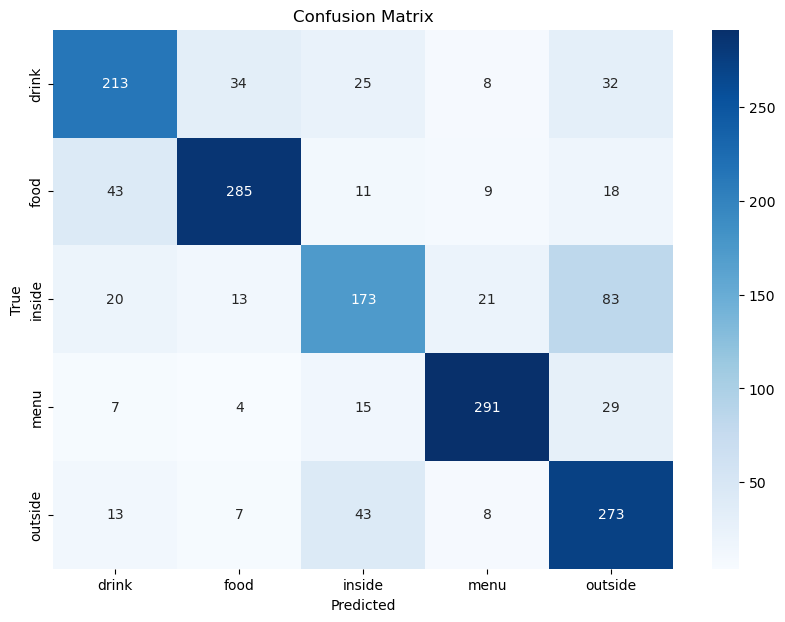

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))
    


Classification Report:
              precision    recall  f1-score   support

       drink       0.72      0.68      0.70       312
        food       0.83      0.78      0.80       366
      inside       0.65      0.56      0.60       310
        menu       0.86      0.84      0.85       346
     outside       0.63      0.79      0.70       344

    accuracy                           0.74      1678
   macro avg       0.74      0.73      0.73      1678
weighted avg       0.74      0.74      0.74      1678



- The f1 scores are low for 2 labels, model tuning can help accurately predict correct labels

In [26]:
# F1 Score
f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

Weighted F1 Score: 0.74


Weighted AUC Score: 0.93


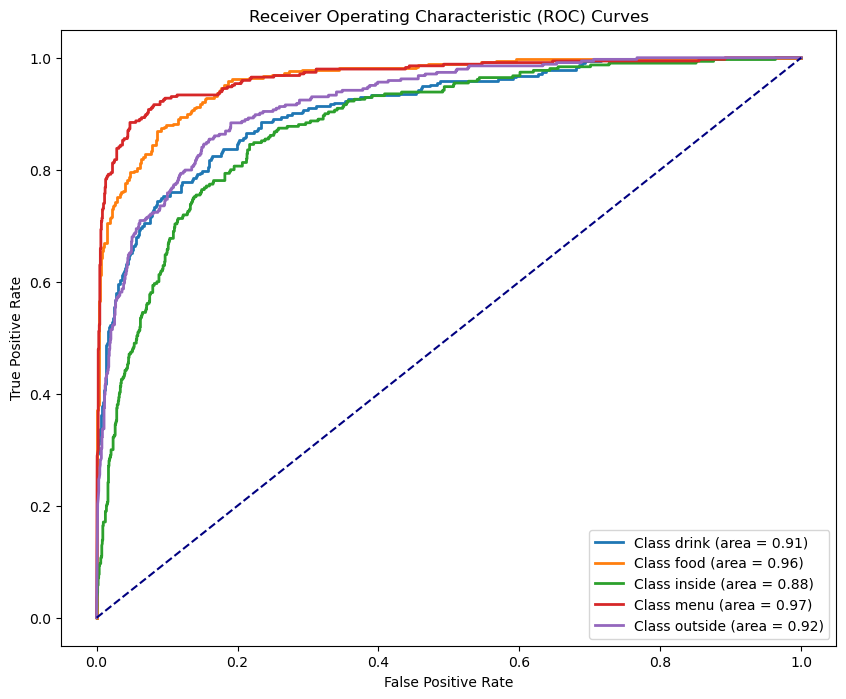

In [27]:
try:
    # Calculate AUC Score for the label-encoded target variable
    auc_score = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr')
    print(f'Weighted AUC Score: {auc_score:.2f}')
except ValueError:
    print("AUC Score calculation failed. It may be due to an insufficient number of positive classes in the predictions.")

# Step 10: Plot ROC Curves for Each Class
plt.figure(figsize=(10, 8))

# Get unique classes from the label encoder
classes = label_encoder.classes_

# Iterate over each class
for i in range(len(classes)):
    # Calculate false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_prob[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

### CNN Model Tuning

- Add regualarization 
- Try different optimizers
- Add more layers
- Add dropout
- Try Strided CNN
- Balance class labels using weights instead
- Drop minority class label and then retrain 

The model is being trained using 256x256 sized images due to which the training time is very high, you guys can try using 128x128 sized images as well if that is the case.

# Tuning 1: Adding Dropout and L2 Regularization

In [28]:
#Defining the L2 regularization value
l2_reg = l2(0.001)

cnn_tune_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  #Adding dropout after the first block

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  #Adding dropout after the second block

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    #Dense layer with L2 regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),  #Adding dropout before the final output layer

    layers.Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2_reg)
])

c:\Users\Rajesh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [29]:
# Compiling the tuned model
cnn_tune_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [30]:
cnn_tune_history = cnn_tune_model.fit(X_train, y_train_encoded,
                             epochs=50,
                             validation_data=(X_test, y_test_encoded),
                             batch_size=32)

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 263ms/step - accuracy: 0.2783 - loss: 2.0090 - val_accuracy: 0.5060 - val_loss: 1.4039
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 262ms/step - accuracy: 0.5065 - loss: 1.3660 - val_accuracy: 0.6001 - val_loss: 1.1904
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 268ms/step - accuracy: 0.5605 - loss: 1.2219 - val_accuracy: 0.5697 - val_loss: 1.1981
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 266ms/step - accuracy: 0.6081 - loss: 1.1156 - val_accuracy: 0.6704 - val_loss: 0.9661
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 270ms/step - accuracy: 0.6343 - loss: 1.0299 - val_accuracy: 0.6996 - val_loss: 0.9038
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 269ms/step - accuracy: 0.6808 - loss: 0.9578 - val_accuracy: 0.6728 - val_loss: 0.9877
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 262ms/step - accuracy: 0.6694 - loss: 0.9766 - val_accuracy: 0.7110 - val_loss: 0.8589
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 261ms/step - accuracy: 0.6962 - loss: 0

After tuning, the model now generalizes better, with a more gradual improvement in accuracy and stabilization of the validation loss. Regularization has helped create a more balanced learning process.

In [31]:
# Prediction 
y_pred_prob_tune = cnn_tune_model.predict(X_test)
y_pred_tune_classes = np.argmax(y_pred_prob_tune, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


In [32]:
# Accuracy Score
tune_accuracy = accuracy_score(y_test_encoded, y_pred_tune_classes)
print(f'Accuracy after Tuning: {tune_accuracy:.4f}')

Accuracy after Tuning: 0.7455


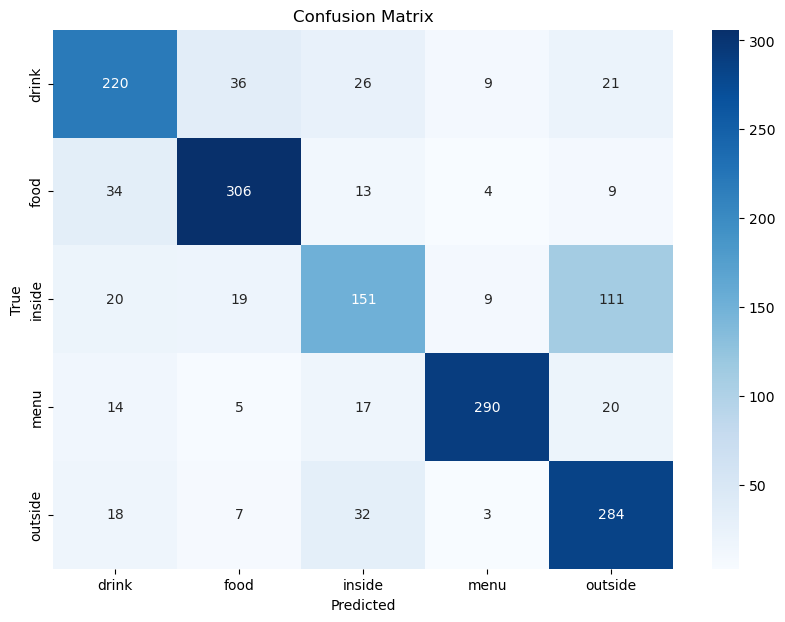

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_tune_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_tune_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       drink       0.72      0.71      0.71       312
        food       0.82      0.84      0.83       366
      inside       0.63      0.49      0.55       310
        menu       0.92      0.84      0.88       346
     outside       0.64      0.83      0.72       344

    accuracy                           0.75      1678
   macro avg       0.75      0.74      0.74      1678
weighted avg       0.75      0.75      0.74      1678



In [35]:
print(df['label'].value_counts())  

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64


### Resolving Imbalance Class

##### Class Weighting-the model learn more effectively from the minority classes like Menu,drinks

In [36]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights (this returns an array)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),  # The encoded class labels
    y=y_train_encoded  # The training labels (encoded)
)

# Convert the array to a dictionary
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Fit the model with the class weights
cnn_tune_model.fit(X_train, y_train_encoded,
                   epochs=10,
                   validation_data=(X_test, y_test_encoded),
                   batch_size=32,
                   class_weight=class_weights)


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 256ms/step - accuracy: 0.8473 - loss: 0.6159 - val_accuracy: 0.7557 - val_loss: 0.9256
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 270ms/step - accuracy: 0.8541 - loss: 0.5958 - val_accuracy: 0.7569 - val_loss: 0.9244
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.8500 - loss: 0.5857 - val_accuracy: 0.7640 - val_loss: 0.9308
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 54s 257ms/step - accuracy: 0.8461 - loss: 0.6083 - val_accuracy: 0.7342 - val_loss: 0.9518
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step - accuracy: 0.8516 - loss: 0.6074 - val_accuracy: 0.7539 - val_loss: 0.9360
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 54s 255ms/step - accuracy: 0.8484 - loss: 0.6172 - val_accuracy: 0.7515 - val_loss: 0.9516
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.8515 - loss: 0.6088 - val_accuracy: 0.7604 - val_loss: 0.9005
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 54s 256ms/step - accuracy: 0.8657 - loss: 0

In [37]:
# Prediction 
y_pred_prob_tune = cnn_tune_model.predict(X_test)
y_pred_tune_classes = np.argmax(y_pred_prob_tune, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


In [38]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_tune_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       drink       0.78      0.68      0.72       312
        food       0.86      0.78      0.82       366
      inside       0.62      0.67      0.64       310
        menu       0.79      0.92      0.85       346
     outside       0.75      0.74      0.74       344

    accuracy                           0.76      1678
   macro avg       0.76      0.76      0.76      1678
weighted avg       0.76      0.76      0.76      1678



In [39]:
print(df['label'].value_counts())  

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64


In [40]:

class_labels = label_encoder.classes_  

# Printing class label to index mapping
for idx, label in enumerate(class_labels):
    print(f"Class label '{label}' is encoded as {idx}")

Class label 'drink' is encoded as 0
Class label 'food' is encoded as 1
Class label 'inside' is encoded as 2
Class label 'menu' is encoded as 3
Class label 'outside' is encoded as 4


#### Random oversampling for minority class

In [41]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Current class distribution (for your reference)
print("Class distribution before oversampling:")
print(pd.Series(y_train_encoded).value_counts())

# Define the RandomOverSampler to oversample 'menu' (class 3) and 'drink' (class 0)
oversample = RandomOverSampler(sampling_strategy={3: 10000, 0: 30000})  # 10,000 for menu, 30,000 for drink

# Step 1: Flatten the image data (assuming X_train has shape (samples, height, width, channels))
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D (samples, height * width * channels)

# Step 2: Apply RandomOverSampler to the flattened data
X_resampled_flattened, y_resampled = oversample.fit_resample(X_train_flattened, y_train_encoded)

# Step 3: Reshape the resampled data back to the original image shape
X_resampled = X_resampled_flattened.reshape(X_resampled_flattened.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_resampled).value_counts())

# Now you can use X_resampled and y_resampled to train your model
cnn_tune_model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))


Class distribution before oversampling:
2    1368
0    1366
4    1334
3    1332
1    1312
dtype: int64
Class distribution after oversampling:
0    30000
3    10000
2     1368
4     1334
1     1312
dtype: int64
Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 382s 277ms/step - accuracy: 0.9286 - loss: 0.4230 - val_accuracy: 0.7521 - val_loss: 0.9173
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 379s 276ms/step - accuracy: 0.9377 - loss: 0.3847 - val_accuracy: 0.7104 - val_loss: 0.9925
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 393s 285ms/step - accuracy: 0.9398 - loss: 0.3649 - val_accuracy: 0.6853 - val_loss: 1.0015
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 386s 280ms/step - accuracy: 0.9397 - loss: 0.3536 - val_accuracy: 0.7318 - val_loss: 0.9263
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 385s 280ms/step - accuracy: 0.9394 - loss: 0.3594 - val_accuracy: 0.6347 - val_loss: 1.2826
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 368s 268ms/step - accuracy: 0.9373 - loss: 0.3552 - val_accuracy: 0.6669 - val

In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_label(model, image_path, class_labels):
    """
    This function takes an image, preprocesses it, and returns the predicted label using class_labels from label_encoder.
    
    Parameters:
    model -- the trained CNN model
    image_path -- the path to the image to be predicted
    class_labels -- the list of class labels from label_encoder.classes_
    
    Returns:
    predicted_label -- the predicted label of the image
    """

    # Step 1: Load the image and resize it to the required dimensions
    img = image.load_img(image_path, target_size=(128, 128))  # Adjust size based on your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    # Step 2: Predict using the model
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])  # Get the index of the highest prediction score

    # Step 3: Map the predicted index to the actual class label using class_labels list
    predicted_label = class_labels[predicted_index]

    return predicted_label


In [62]:
class_weights = {0: 1.5, 1: 1.0, 2: 2.0, 3: 3.0, 4: 2.5}  # Higher weight for drinks and outside
# Fit the model with the class weights
cnn_tune_model.fit(X_train, y_train_encoded,
                   epochs=10,
                   validation_data=(X_test, y_test_encoded),
                   batch_size=32,
                   class_weight=class_weights)

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 63s 299ms/step - accuracy: 0.8755 - loss: 0.9233 - val_accuracy: 0.7753 - val_loss: 1.1361
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 64s 303ms/step - accuracy: 0.8731 - loss: 0.9379 - val_accuracy: 0.7646 - val_loss: 1.1304
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 70s 332ms/step - accuracy: 0.8848 - loss: 0.8755 - val_accuracy: 0.7652 - val_loss: 1.1218
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 69s 330ms/step - accuracy: 0.8757 - loss: 0.8885 - val_accuracy: 0.7676 - val_loss: 1.0758
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.8764 - loss: 0.9323 - val_accuracy: 0.7753 - val_loss: 1.1067
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - accuracy: 0.8802 - loss: 0.8897 - val_accuracy: 0.7747 - val_loss: 1.0809
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 61s 289ms/step - accuracy: 0.8803 - loss: 0.8880 - val_accuracy: 0.7622 - val_loss: 1.1626
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 61s 289ms/step - accuracy: 0.8854 - loss: 0

In [68]:
# Prediction 
y_pred_prob_tune = cnn_tune_model.predict(X_test)
y_pred_tune_classes = np.argmax(y_pred_prob_tune, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


In [69]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_tune_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       drink       0.77      0.73      0.75       312
        food       0.83      0.85      0.84       366
      inside       0.67      0.58      0.62       310
        menu       0.80      0.95      0.86       346
     outside       0.78      0.73      0.75       344

    accuracy                           0.77      1678
   macro avg       0.77      0.77      0.77      1678
weighted avg       0.77      0.77      0.77      1678



In [70]:
cnn_tune_model.save('CNN_Model.h5')  # Save the trained model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


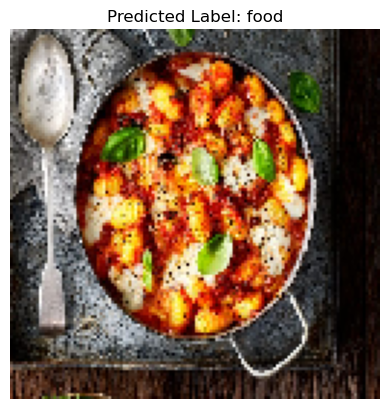

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


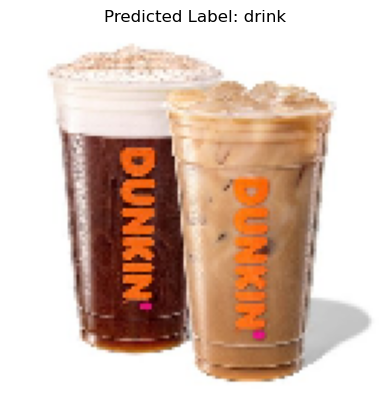

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


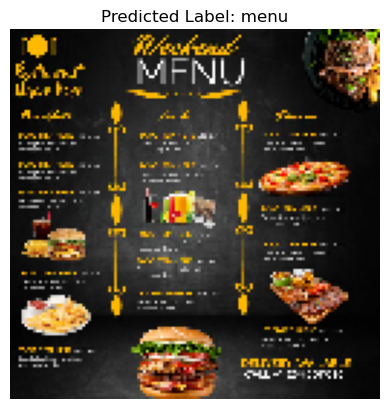

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


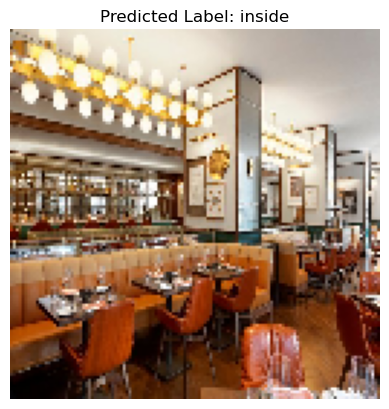

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


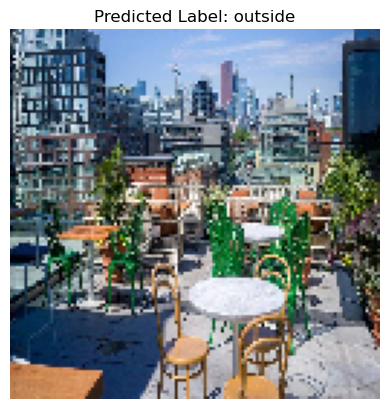

In [75]:
# Assuming your model is trained and loaded
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('CNN_Model.h5')


# List of class labels from the label encoder
class_labels = label_encoder.classes_  # This contains the list of all class labels

# List of 5 image paths
image_paths = ['food1.jpg', 'drinks1.jpg', 'menu1.jpg', 'inside1.jpg', 'outside1.jpg']  # Replace with actual image paths
# Loop over the image files, predict the labels, and display the results
for image_path in image_paths:
    # Predict the label for each image
    predicted_label = predict_image_label(model, image_path, class_labels)
    
    # Load the image for display
    img = image.load_img(image_path, target_size=(128, 128))
    
    # Plot the image
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}")  # Display the predicted label as the title
    plt.axis('off')  # Turn off axis display
    plt.show()  # Show the image with the predicted label

### Interpretebility

### Saliency Maps (for CNNs)
It highlight which pixels of an image are most influential in the model's prediction.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


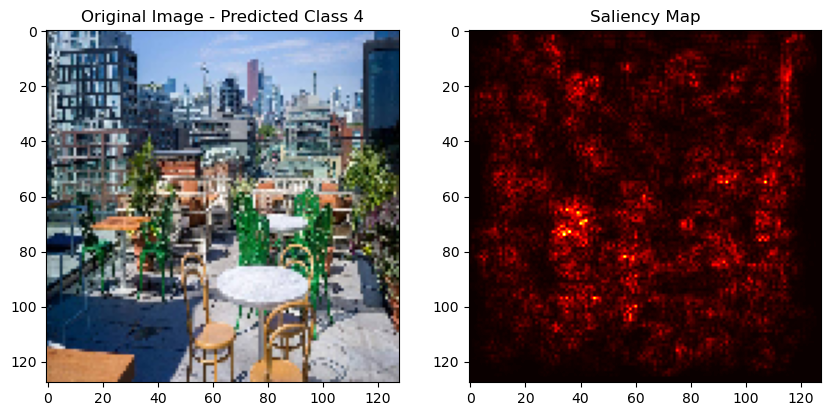

In [76]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, img_array, class_idx):
    # Create a gradient tape for recording operations
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)  # Watch the image for gradient computation
        predictions = model(img_tensor)  # Get model predictions
        loss = predictions[:, class_idx]  # Get the score for the specific class
        
    # Compute the gradient of the output w.r.t the input image
    gradients = tape.gradient(loss, img_tensor)
    
    # Get the absolute values of the gradient and normalize them
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))
    
    return saliency_map

# Example: Use the model and image to compute the saliency map
image_path = 'outside1.jpg'  # Replace with your image
img = image.load_img(image_path, target_size=(128, 128))  # Adjust size to match model input
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

# Predict class and compute saliency map
class_idx = np.argmax(model.predict(img_array))  # Get the predicted class index
saliency_map = compute_saliency_map(model, img_array, class_idx)

# Plot the image and the saliency map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image - Predicted Class {class_idx}')
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.show()


### Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

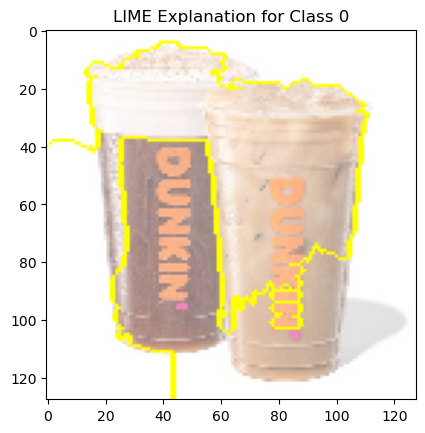

In [77]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load and preprocess the image
image_path = 'drinks1.jpg'
img = image.load_img(image_path, target_size=(128, 128))
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the image
explanation = explainer.explain_instance(
    image=img_array[0].astype('double'),
    classifier_fn=model.predict,  # Your model's prediction function
    top_labels=5,  # Top 5 class labels to explain
    hide_color=0,  # Color to hide portions of the image
    num_samples=1000  # Number of perturbations
)

# Get the explanation for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Predicted class
    positive_only=True,  # Show only the regions that positively contribute
    num_features=5,  # Number of features (superpixels) to highlight
    hide_rest=False  # Show the entire image with the highlighted region
)

# Plot the explanation
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME Explanation for Class {explanation.top_labels[0]}")
plt.show()


### SHAP

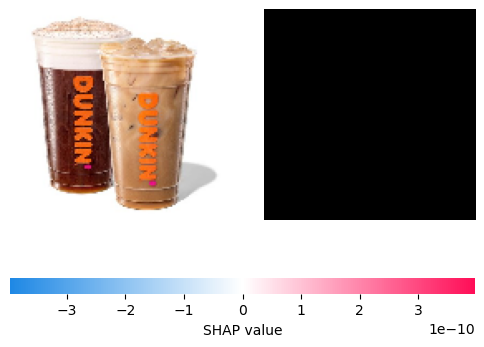

In [78]:
import shap

# Initialize the SHAP explainer
explainer = shap.GradientExplainer(model, X_train)  # Use a subset of your training data

# Compute SHAP values for a given image
shap_values = explainer.shap_values(img_array)

# Plot the SHAP values for the top predicted class
shap.image_plot(shap_values, img_array)


In [79]:
# Save the model in the TensorFlow SavedModel format
cnn_model.save('cnn_model')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=cnn_model.